# 案例：量化交易策略的预测

<div class="alert alert-block alert-success">
本案例研究的目标是使用基于分类的模型，根据短期价格和长期价格预测当前信号是买入还是卖出。
</div>


## 问题定义

为交易策略预测买入或卖出信号的问题是在分类框架中定义的，其中预测变量的值为 1 表示买入，0 表示卖出。

买入或卖出信号是根据短期价格与长期价格的比较来决定的。

为了进行案例研究，我们从日均交易量最大的比特币交易所之一--Bitstamp（https:// www.bitstamp.com）获取数据。数据可在以下网址找到： https://www.kaggle.com/mczielinski/bitcoin-historical-data

## 读取数据集

In [190]:
import pandas as pd
dataset = pd.read_csv('datasets/BitstampData_sample.csv')

## 描述性统计

In [157]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [139]:
# describe data
#set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


## 数据准备

### 数据清洗

In [140]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


鉴于存在空值，我们需要用最后可用的值填充 NaN，从而清理数据。

In [141]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [142]:
dataset=dataset.drop(columns=['Timestamp'])

### 准备分类数据

我们为每一个走势贴上标签：

- 如果信号显示短期价格将比长期价格上涨，则标记为 1；
- 如果信号显示短期价格将比长期价格下跌，则标记为 0。


In [143]:
import numpy as np

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [144]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
4857372,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,58695.262,58667.759333,1.0
4857373,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,58693.564,58667.410167,1.0
4857374,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,58698.178,58667.708333,1.0
4857375,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,58709.824,58668.532333,1.0
4857376,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363,58718.698,58670.550500,1.0


### 特征工程——构建技术指标

首先，我们要构建一个数据集，其中包含用于预测的预测因子和输出变量。

双币的当前数据包括日期、开盘价、最高价、最低价、收盘价和成交量。利用这些数据，我们可以计算出以下技术指标：

- 移动平均线：移动平均线通过减少价格图表上的 "噪音 "量来显示价格变动的趋势。
- 随机震荡指标 %K 和 %D：随机震荡指标是一种动量指标，将证券的特定收盘价与一定时期内的价格范围进行比较。%K 和 %D 是慢速和快速指标。
- 相对强弱指数（RSI）：这是一种动量指标，用于衡量近期价格变化的幅度，以评估股票或其他资产价格的超买或超卖情况。
- 变化率（ROC）： 这是一种动量震荡指标，用于测量当前价格与过去 N 期价格之间的百分比变化。
- 动量（MOM）：是指证券价格或成交量的加速率，即价格变化的速度。

In [145]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

In [146]:

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)


In [147]:

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)


In [148]:
#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

In [149]:
#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [150]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,58695.262,58667.759333,1.0,...,49.479206,35.393068,61.578052,51.696846,68.137666,39.264052,47.839895,58695.262,58676.974333,58717.26280
4857373,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,58693.564,58667.410167,1.0,...,49.477515,35.232460,44.601858,51.582924,57.317024,34.155329,39.805778,58693.564,58675.469333,58717.92555
4857374,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,58698.178,58667.708333,1.0,...,49.822376,67.379544,46.001691,74.385418,59.221729,41.880662,38.433347,58698.178,58675.542333,58718.66155
4857375,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,58709.824,58668.532333,1.0,...,50.152827,91.130640,64.580881,94.261430,73.409924,51.700826,42.578939,58709.824,58675.947000,58719.38035
4857376,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363,58718.698,58670.550500,1.0,...,50.310243,100.000000,86.170061,100.000000,89.548949,56.401144,49.994210,58718.698,58677.057000,58720.38225


In [151]:
#excluding columns that are not needed for our prediction.
dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [152]:
dataset = dataset.dropna(axis=0)

In [153]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58686.00,1.384487,58692.753339,1.0,58691.231169,58675.537971,58722.002882,-0.028602,-0.076552,19.46,...,49.479206,35.393068,61.578052,51.696846,68.137666,39.264052,47.839895,58695.262,58676.974333,58717.26280
4857373,58685.81,7.294848,58693.226508,1.0,58690.245502,58676.200682,58721.642754,0.013821,-0.061034,-16.98,...,49.477515,35.232460,44.601858,51.582924,57.317024,34.155329,39.805778,58693.564,58675.469333,58717.92555
4857374,58723.84,1.705682,58696.198496,1.0,58696.353592,58679.274187,58721.664617,0.135922,-0.041890,46.14,...,49.822376,67.379544,46.001691,74.385418,59.221729,41.880662,38.433347,58698.178,58675.542333,58718.66155
4857375,58760.59,0.720415,58761.866202,1.0,58708.032939,58684.520368,58722.051935,0.121231,0.026743,116.46,...,50.152827,91.130640,64.580881,94.261430,73.409924,51.700826,42.578939,58709.824,58675.947000,58719.38035
4857376,58778.18,2.712831,58764.349363,1.0,58720.786950,58690.562925,58722.610423,0.133356,0.071762,88.74,...,50.310243,100.000000,86.170061,100.000000,89.548949,56.401144,49.994210,58718.698,58677.057000,58720.38225


### 数据可视化

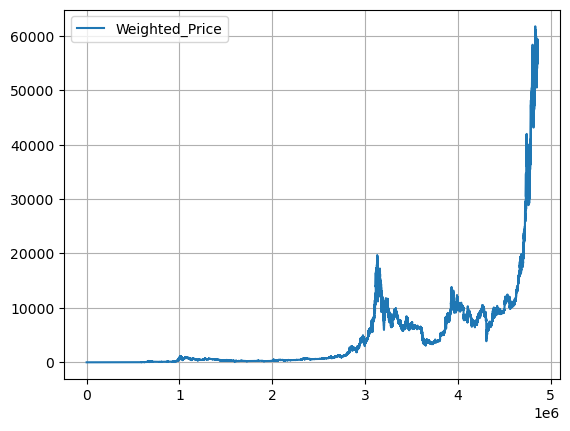

In [154]:
import matplotlib.pyplot as plt
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

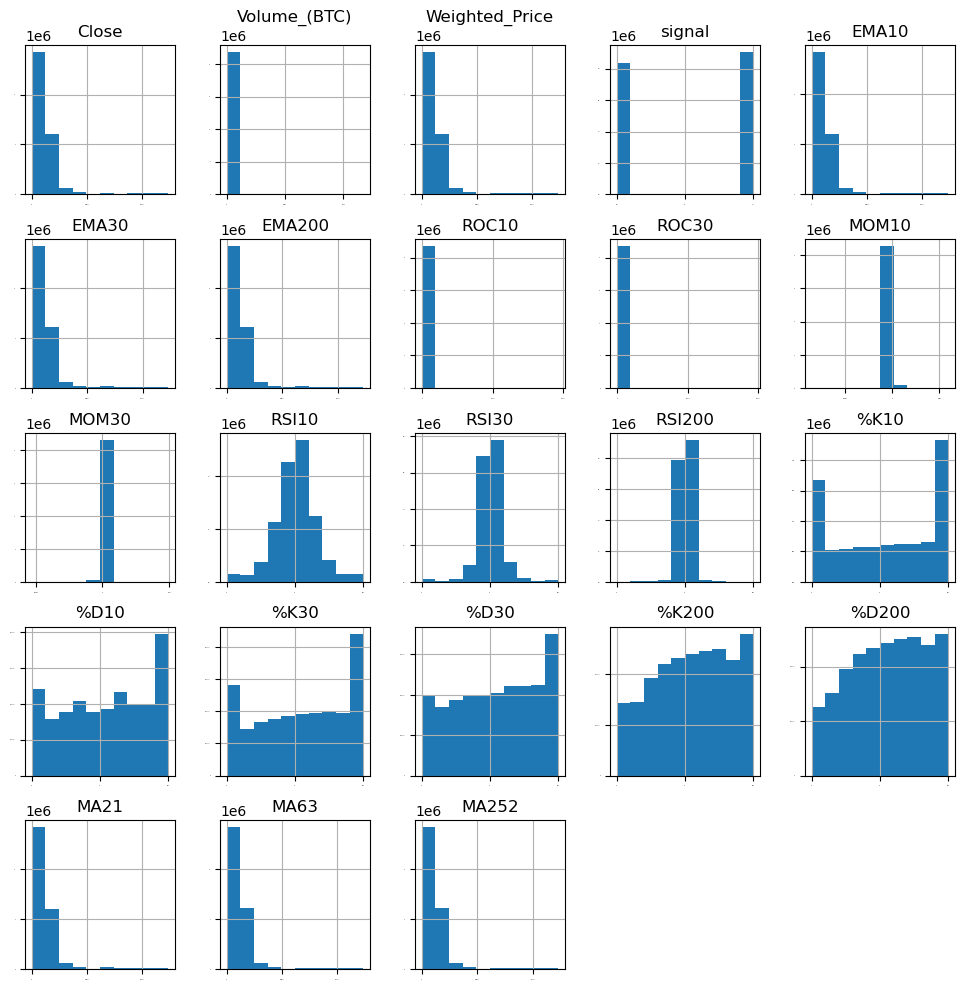

In [155]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

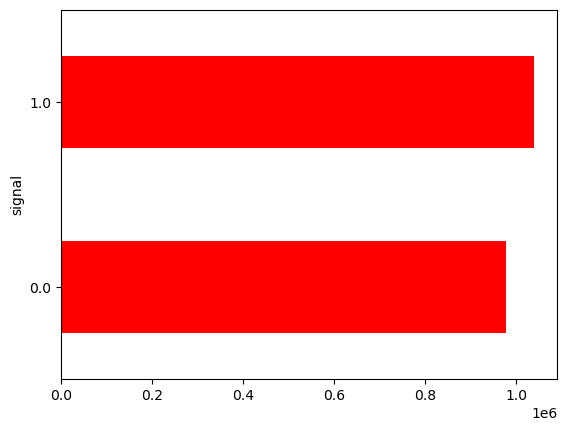

In [64]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

买入信号的数量多于卖出信号的数量

<Axes: title={'center': 'Correlation Matrix'}>

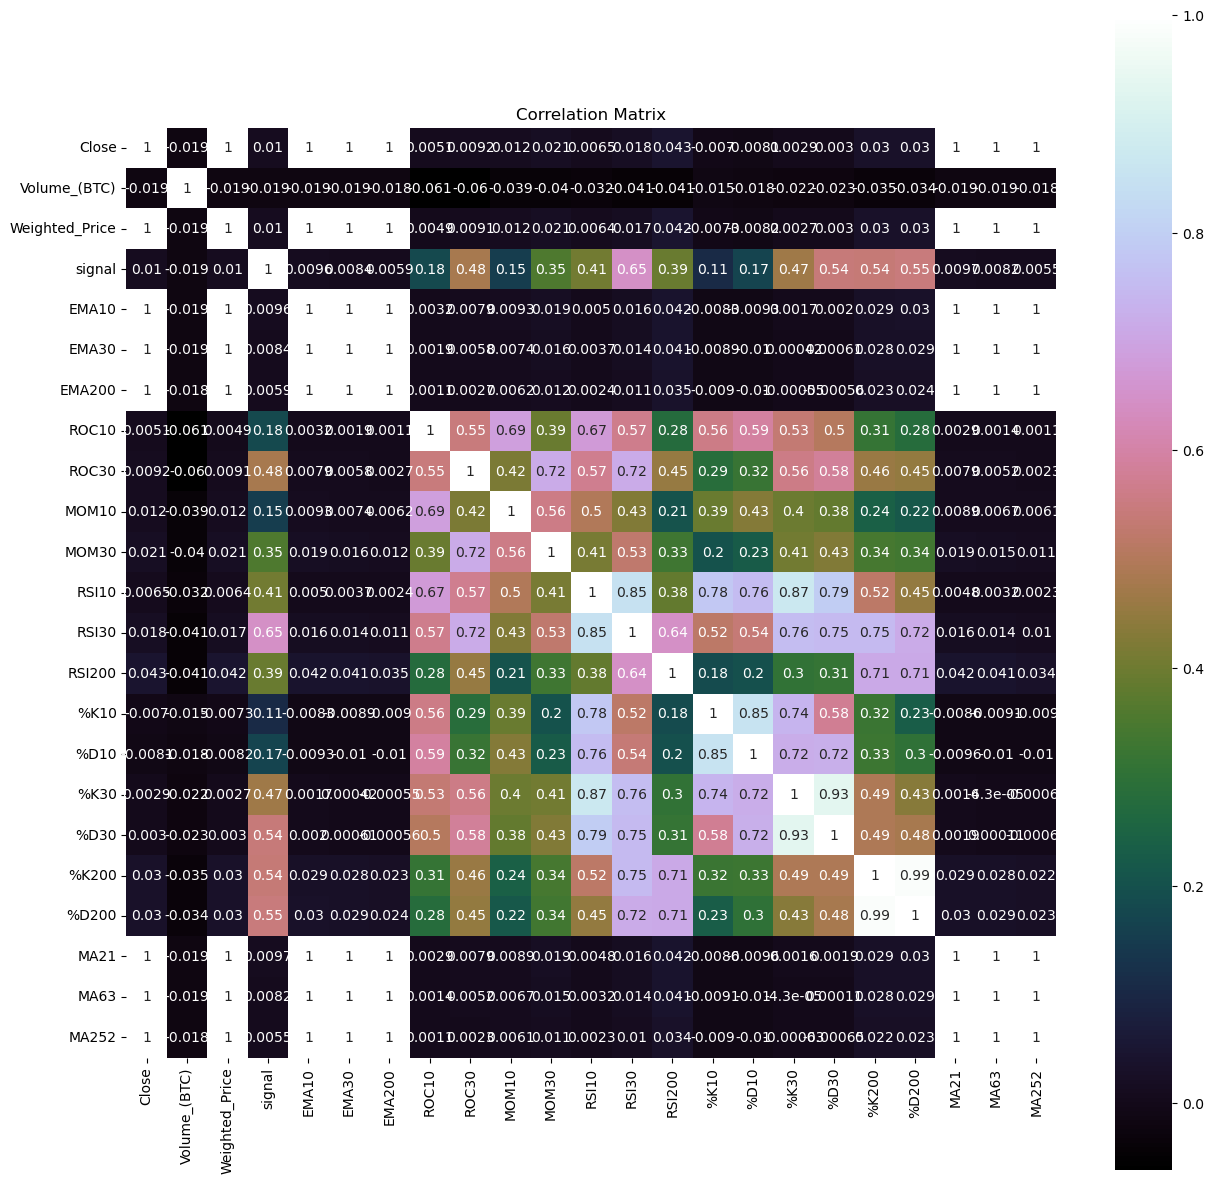

In [66]:
# correlation
import seaborn as sns
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

## 建模和评估算法

### 训练集/测试集划分

In [68]:
# split out validation dataset for the end
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

### 模型表现

In [69]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [78]:
# spot check the algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [79]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

LR: 0.926412 (0.021625)
CART: 0.897400 (0.003025)
RF: 0.930350 (0.003973)


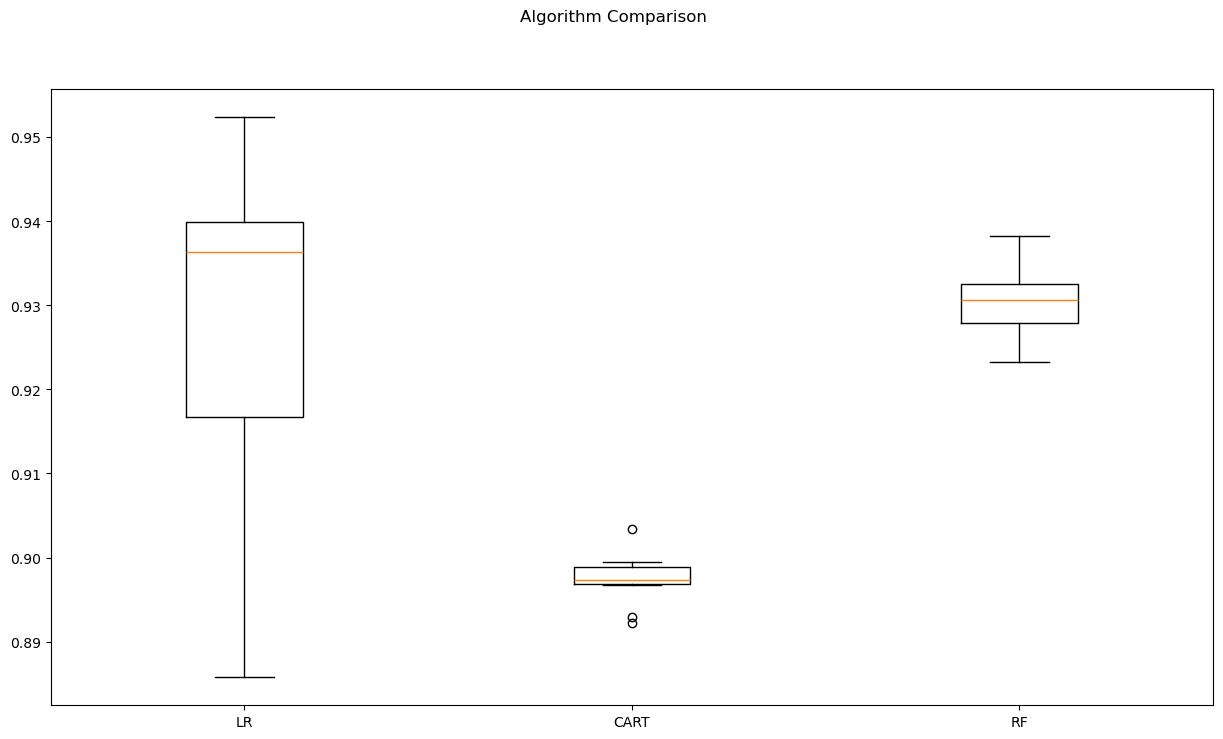

In [80]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

### 测试集表现

In [81]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [84]:
# estimate accuracy on validation set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.91665
[[8534  879]
 [ 788 9799]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      9413
         1.0       0.92      0.93      0.92     10587

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



### 特征重要性排序

Text(0.5, 0, 'Variable Importance')

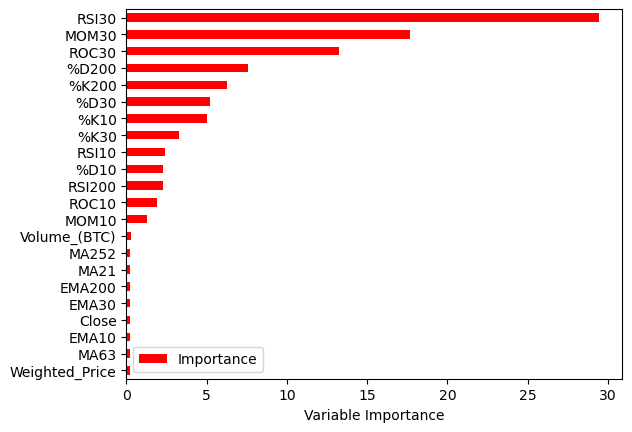

In [85]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

## 回测

<Axes: >

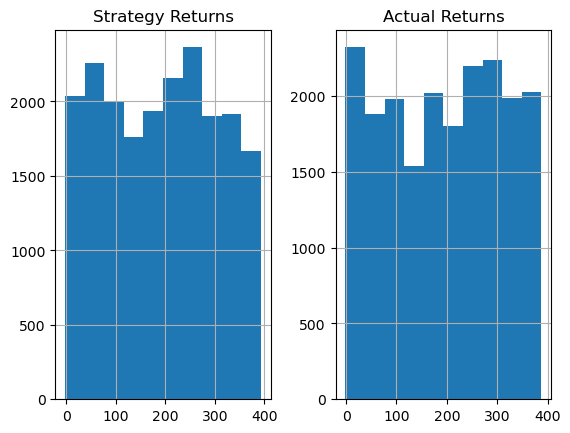

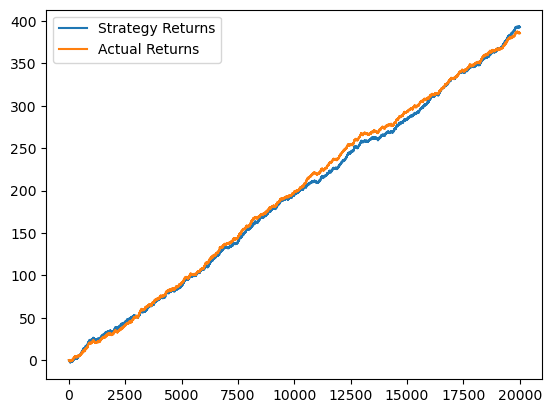

In [86]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

## 结论

我们展示了使用特征工程的效率，它可以创建与价格变动趋势和动量相关的直观特征，并提高模型的预测能力。

就基于分类的交易策略的评估指标而言，准确率或 auc 都是合适的，但如果该策略的重点是在做多的同时提高准确率，那么与准确率相比，我们更倾向于采用注重减少误报的召回率指标。

最后，我们演示了回溯测试框架，该框架允许我们使用历史数据模拟交易策略，以生成结果，并在投入任何实际资金之前分析风险和盈利能力。

## 参考